# Risk Parity Project
**Hang Xu; Jiaren Ma, Yuzhou Liu, Qinhan Shen**

In [3]:
#Package
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override() 
import datetime 
from collections import OrderedDict
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

## Define Funtions

In [4]:
# Define functions
def cov_ewma(ret_assets, lamda = 0.94):
    ret_mat = ret_assets.values
    T = len(ret_assets)
    coeff = np.zeros((T,1))
    S = ret_assets.cov()
    for i in range(1, T):
#        S = lamda * S  + (1-lamda)*np.matmul(ret_mat[i-1,:].reshape((-1,1)), 
#                          ret_mat[i-1,:].reshape((1,-1)))
        S = lamda * S  + (1-lamda)* (ret_mat[i-1,:].reshape((-1,1)) @ ret_mat[i-1,:].reshape((1,-1)) )
        coeff[i] = (1-lamda)*lamda**(i)
    return S/np.sum(coeff)

# risk budgeting approach optimisation object function
def obj_fun(W, cov_assets, risk_budget):
    var_p = np.dot(W.transpose(), np.dot(cov_assets, W))
    sigma_p = np.sqrt(var_p)
    risk_contribution = W*np.dot(cov_assets, W)/sigma_p
    risk_contribution_percent = risk_contribution/sigma_p
    return np.sum((risk_contribution_percent-risk_budget)**2)


# calculate risk budgeting portfolio weight give risk budget
def riskparity_opt(ret_assets, risk_budget, lamda, method='ewma',Wts_min = 0.0, leverage=False):
    # number of assets
    num_assets = ret_assets.shape[1]
    # covariance matrix of asset returns
    if method == 'ewma':
        cov_assets = cov_ewma(ret_assets, lamda)
    elif method == 'ma':
        cov_assets = ret_assets.cov()
    else:
        cov_assets = cov_ewma(ret_assets, lamda)        
    
    # initial weights
    w0 = 1.0 * np.ones((num_assets, 1)) / num_assets
    # constraints
    # cons = ({'type': 'eq', 'fun': cons_sum_weight}, {'type': 'ineq', 'fun': cons_long_only_weight})
    if leverage == True:
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-2. }, # Sum of weights = 200%
              {'type':'ineq', 'fun': lambda W: W-Wts_min}) # weights greater than min wts
    else:
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. }, # Sum of weights = 100%
              {'type':'ineq', 'fun': lambda W: W-Wts_min}) # weights greater than min wts
    # portfolio optimisation
    return minimize(obj_fun, w0, args=(cov_assets, risk_budget), method='SLSQP', constraints=c_)


# function to get the price data from yahoo finance 
def getDataBatch(tickers, startdate, enddate):
  def getData(ticker):
    return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
  datas = map(getData, tickers)
  return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))


## Capture Historical Data from Yahoo

In [5]:
#Get historical data
start_dt = datetime.datetime(2007, 12, 31)
end_dt = datetime.datetime(2018, 12, 31)

tickers = ['AGG','SUSA','GLD','EEM']
stock_data = getDataBatch(tickers, start_dt, end_dt)
# Isolate the `Adj Close` values and transform the DataFrame
daily_close_px = stock_data.reset_index().pivot(index='Date', columns='Ticker', values='Adj Close')

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


## Build Risk Parity Model

In [6]:
#Calculate Portfolio Return
ret_assets = daily_close_px.pct_change().dropna()
ret_assets_demean = ret_assets - ret_assets.mean()
num_assets = ret_assets_demean.shape[1]

lamda = 0.94
SS = cov_ewma(ret_assets_demean, lamda)
datestr = daily_close_px.index[daily_close_px.index >= '2008-01-02']
  # previous month
mth_previous = datestr[0]
# initialise portfolio weights matrix
wts = pd.DataFrame(index=datestr, columns=ret_assets.columns)
# initialise portfolio return matrix
ret_riskParity = pd.DataFrame(index=datestr, columns=['Risk Parity'])

# how many rolling calendar days to use for covariance calculation  
window = 90
Wts_min = 0.0
risk_budget = 1.0/num_assets*np.ones([1,num_assets]) #risk-party
#risk_budget = [0.7, 0.4]
leverage = True
varmodel = 'ewma'

for t in datestr:
    # construct risk budgeting portfolio and re-balance on monthly basis
    if t.month == mth_previous:
        # keep the same portfolio weights within the month
        wts.loc[t] = wts.iloc[wts.index.get_loc(t)-1]
    else:
        # update the value of the previous month 
        mth_previous = t.month
        # re-balance the portfolio at the start of the month
        
        t_begin = t - timedelta(days = window)
        ret_used = ret_assets.loc[t_begin:t,:]
        wts.loc[t] = riskparity_opt(ret_used, risk_budget, lamda, varmodel, Wts_min, leverage).x
    # calculate risk budgeting portfolio returns
    ret_riskParity.loc[t] = np.sum(wts.loc[t] * ret_assets.loc[t])
    
# Due to precision issue, wts could be a tiny negative number instead of zero, make them zero
wts[wts<Wts_min]=Wts_min
wts=wts.drop(wts.index[0:29], axis=0)
# Construct equal weighted portfolio
ret_equalwted = pd.DataFrame(np.sum(1.0*ret_assets[ret_assets.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])


## Performance Measurements

In [7]:
# Calculate performance stats
ret_cumu_assets = (ret_assets + 1).cumprod()
ret_cumu_riskP = (ret_riskParity + 1).cumprod()
ret_cumu_equalwt = (ret_equalwted + 1).cumprod()

ret_annual_assets = ret_cumu_assets.iloc[-1]**(250/len(ret_cumu_assets))-1
std_annual_assets = ret_assets.std()*np.sqrt(250)
sharpe_ratio_assets = ret_annual_assets/std_annual_assets

ret_annual_riskP = ret_cumu_riskP.iloc[-1]**(250/len(ret_cumu_riskP))-1
std_annual_riskP = ret_riskParity.std()*np.sqrt(250)
sharpe_ratio_riskP = ret_annual_riskP/std_annual_riskP

ret_annual_equalwt = ret_cumu_equalwt.iloc[-1]**(250/len(ret_cumu_equalwt))-1
std_annual_equalwt = ret_equalwted.std()*np.sqrt(250)
sharpe_ratio_equalwt = ret_annual_equalwt/std_annual_equalwt

#sharpe_table = [sharpe_ratio_riskP, sharpe_ratio_equalwt]
sharpe_table = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                 ('equal_wted', sharpe_ratio_equalwt.values),
                 )))
sharpe_table1 = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                 ('AGG', sharpe_ratio_assets[0]),
                 ('EEM', sharpe_ratio_assets[1]),
                  ('SUSA', sharpe_ratio_assets[2]),
                   ('USO', sharpe_ratio_assets[3])
                 )))
print('sharpe ratio of different strategies:\n',sharpe_table)
print('\nsharpe ratio of strategies vs assets:\n',sharpe_table1)

sharpe ratio of different strategies:
 risk_parity    [0.5352810169726517]
equal_wted     [0.3228907226123428]
dtype: object

sharpe ratio of strategies vs assets:
 risk_parity    [0.5352810169726517]
AGG                        0.696477
EEM                     -0.00783328
SUSA                       0.192065
USO                        0.281687
dtype: object


## Plotting

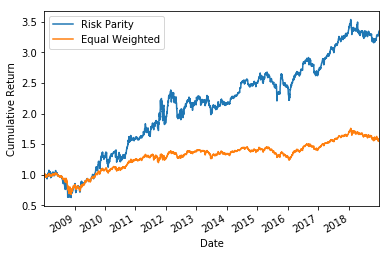

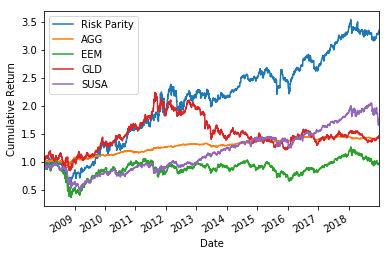

Text(0,0.5,'asset weights')

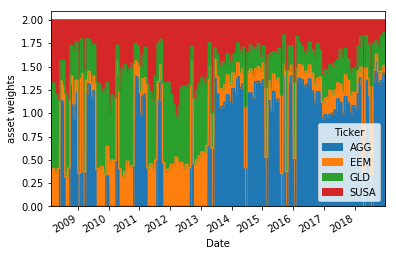

In [8]:
# compare the portfolio cumulative returns
figure_count = 1
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_equalwt], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.show()

# compare the portfolio cumulative returns vs. asset returns
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_assets], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.show()

# plot the historical weights of the assets
# area plot showing the weights
plt.figure(figure_count)
figure_count = figure_count + 1
wts.plot.area()
plt.ylabel('asset weights')